In [2]:
import matplotlib.pyplot as plt
import pennylane as qml

In [3]:
def XOR(qubit1, qubit2, qubit3, qubit_out):
    qml.CNOT(wires=[qubit1, qubit_out])
    qml.CNOT(wires=[qubit2, qubit_out])
    qml.CNOT(wires=[qubit3, qubit_out])


def apply_constraints():
    XOR(0, 1, 2, 9)
    XOR(3, 4, 5, 10)
    XOR(6, 7, 8, 11)
    XOR(0, 3, 6, 12)
    XOR(1, 4 ,7, 13)
    XOR(2, 5, 8, 14)


def oracle(constraint_quibts, out_qubit):
    apply_constraints()
    qml.MultiControlledX(control_wires=constraint_quibts, wires=out_qubit, control_values=[1]*len(constraint_quibts))
    apply_constraints()


def diffuser(variable_qubits, out_qubit):
    for wire in variable_qubits:
        qml.Hadamard(wires=wire)
    qml.MultiControlledX(control_wires=variable_qubits, wires=out_qubit, control_values=[0]*len(variable_qubits))
    for wire in variable_qubits:
        qml.Hadamard(wires=wire)
        

def init(variable_qubits, out_qubit):
    qml.PauliX(wires=out_qubit)
    qml.Hadamard(wires=out_qubit)
    for wire in variable_qubits:
        qml.Hadamard(wires=wire)


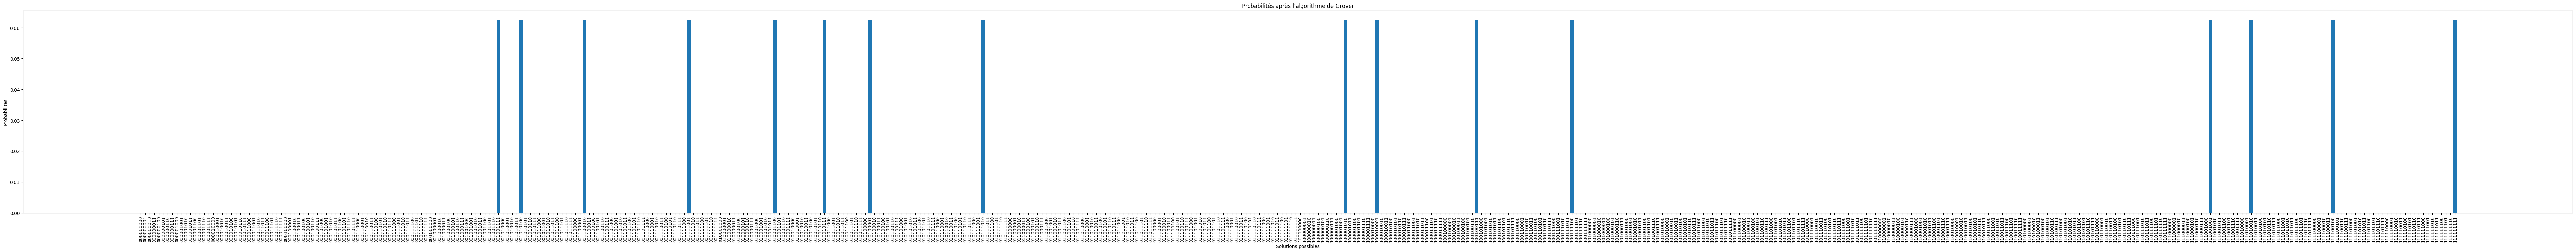

In [22]:
n_qubits = 16
variable_qubits = [0,1,2,3,4,5,6,7,8]
constraint_quibts = [9,10,11,12,13,14]
out_qubit = 15

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def grover_circuit(variable_qubits, constraint_quibts, out_qubit, nb_iters):
    init(variable_qubits, out_qubit)
    for _ in range(nb_iters):
        oracle(constraint_quibts, out_qubit)
        diffuser(variable_qubits, out_qubit)

    return qml.probs(wires=variable_qubits)



probabilities = grover_circuit(variable_qubits, constraint_quibts, out_qubit, 4)

states = [f"{i:09b}" for i in range(2**len(variable_qubits))]
plt.figure(figsize=(100,8))
plt.bar(states, probabilities)
plt.xlabel("Solutions possibles")
plt.ylabel("Probabilités")
plt.title("Probabilités après l'algorithme de Grover")
plt.xticks(rotation=90)
plt.show()


## (a) Combien y a-t-il de combinaisons possibles pour un sudoku 3x3 ?

Il y a 512 combinaisons possibles

## (b) Combien y a-t-il de solutions possibles ?

Il y a 16 solutions possibles

## (c) Quel est le nombre optimal d’itérations de Vf et W dans le circuit ? Présentez vos calculs.

D'après la réponse d de la partie 1.1, on a :
$$k \approx \frac{\pi}{4} \times \frac{\sqrt{N}}{\sqrt{m}} - \frac{1}{2}$$
Dans notre cas, N = 512 et m = 16, ce qui donne :
$$ k \approx 3.92 \approx 4$$
Le nombre optimal d'itérations de Vf et W dans le circuit est donc 4.

## (d) Quelle est la probabilité de succès ?

La probabilité de succés vaut :
$$
\sin\left((2k + 1)\theta\right)^2 = \sin\left((2k + 1)arcsin(\frac{\sqrt{m}}{\sqrt{N}})\right)^2 \approx 0.999
$$

## (e) Représentez graphiquement le circuit complet à simuler.

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


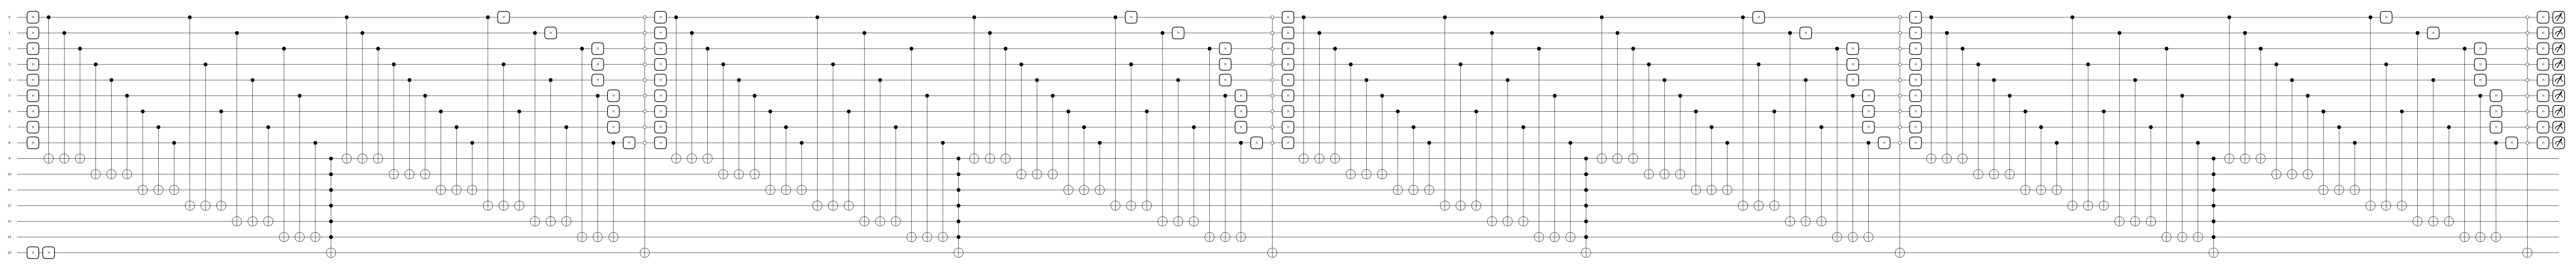

In [23]:
fig, ax = qml.draw_mpl(grover_circuit)(variable_qubits, constraint_quibts, out_qubit, 4)
plt.show()

## (f) Combien de portes CNOT faut-il pour rouler le circuit sur une machine réelle ?

In [24]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.operation import Operation
from pennylane.measurements import MeasurementProcess
from pennylane.transforms import create_expand_fn

# les portes de base de notre expansion 
# je triche ici en rajoutant RZ, RX, RY 
# mais c'est surement ok vu que ce qui nous intéresse au final c'est les CNOT
base_gates = ["T", "Adjoint(T)", 
              "S", "Adjoint(S)", 
              "SX", "Adjoint(SX)", 
              "PauliX", "PauliY", "PauliZ", 
              "Hadamard", "CNOT", 
              "RZ", "RX", "RY"]

def decompose(tape : QuantumTape) -> QuantumTape:
    def stop_at(op : Operation):
        return op.name in base_gates

    # pennylane create_expand_fn does the job for us 
    custom_expand_fn = create_expand_fn(depth=9, stop_at=stop_at)
    tape = custom_expand_fn(tape)
    return tape

# une fonction utilitaire qui crée un noeud à partir d'un tape
# ya surement un meilleur moyen de faire ça, mais c'est ce que j'ai
@qml.qnode(dev)
def arbitrary_circuit(tape : QuantumTape, measurement = qml.counts):
    """
    create a quantum function out of a tape and a default measurement to use (overrides the measurements in the tape)
    """
    for op in tape.operations:
        if len(op.parameters) > 0:
            qml.apply(op)
        else:
            qml.apply(op)
    
    def get_wires(mp : MeasurementProcess):
        return [w for w in mp.wires] if mp is not None and mp.wires is not None and len(mp.wires) > 0 else tape.wires

    # retourner une liste de mesures si on a plusieurs mesures, sinon retourner une seule mesure
    return [measurement(wires=get_wires(meas)) for meas in tape.measurements] if len(tape.measurements) > 1 \
        else measurement(wires=get_wires(tape.measurements[0] if len(tape.measurements) > 0 else None))

In [25]:
grover_circuit(variable_qubits, constraint_quibts, out_qubit, 4)
tape = grover_circuit.tape
tape = decompose(tape)

specs = qml.specs(arbitrary_circuit)(tape)
resources = specs["resources"]

print("\n".join([f"{k} : {v}" for k,v in resources.gate_types.items()]))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


PauliX : 73
Hadamard : 2514
CNOT : 7680
RZ : 448
RY : 224
Adjoint(T) : 3648
T : 4864


Il faudrait donc 7680 portes CNOT pour rouler le circuit sur une machine réelle